In [117]:
import torch
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')\

device

device(type='cuda')

In [118]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics



class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, class_list, image_folder):
        self.file_class = class_list
        self.image_folder = image_folder

    def __len__(self):
        return len(self.file_class)
    
    def __getitem__(self, idx):
        image_name = self.file_class.iloc[idx, 0]
        image_path = f"{self.image_folder}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        label = self.file_class.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        preprocessing = v2.Compose([
            v2.Resize((128, 128)),
            v2.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomGrayscale(p=0.1),
            v2.RandomErasing(p=0.3),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]).to(device)

        image = preprocessing(image)

        return image, label

# Dataset split

In [119]:
train_image_label = pd.read_csv('annot/train_info.csv', names=['image_name', 'label'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_image_label, train_size = 0.8, test_size=0.2, random_state=42)
reduced_train_df = []
for i in range(251):
    if train_df[train_df['label'] == i].shape[0] > 100:
        # If there are more than 200 samples, sample 100
        reduced_train_df.append(train_df[train_df['label'] == i].sample(100, random_state=42))
    else:
        # If there are less than 200 samples, take all available samples
        reduced_train_df.append(train_df[train_df['label'] == i])

reduced_train_df = pd.concat(reduced_train_df, ignore_index=True)

e:\AI2025\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0125492].


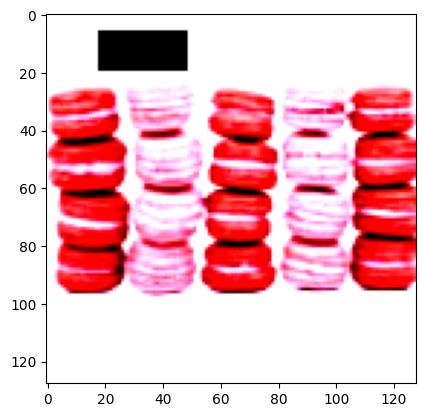

In [120]:
train_dataset = FoodDataset(reduced_train_df, 'train/train_set')
image_train, label_train = train_dataset.__getitem__(0)

plt.imshow(image_train.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [121]:
test_df = pd.read_csv('annot/val_info.csv')

test_dataset = FoodDataset(test_df, 'val/val_set')
test_dataset.__getitem__(0)

e:\AI2025\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(tensor([[[ 1.3927,  1.4098,  1.3927,  ..., -1.2788, -1.3130, -1.3987],
          [ 1.4098,  1.4098,  1.3927,  ..., -1.3644, -1.4329, -1.4843],
          [ 1.3755,  1.3584,  1.3584,  ..., -1.2788, -1.3644, -1.2617],
          ...,
          [ 0.9303,  0.8961,  0.9646,  ...,  0.9474,  0.9474,  0.9474],
          [ 0.9132,  0.8789,  0.9646,  ...,  0.9474,  0.9474,  0.9646],
          [ 0.8618,  0.8447,  0.9303,  ...,  0.9646,  0.9474,  0.9646]],
 
         [[ 1.4307,  1.4482,  1.4307,  ..., -1.1429, -1.1604, -1.2479],
          [ 1.4482,  1.4482,  1.4307,  ..., -1.2654, -1.3529, -1.4055],
          [ 1.4482,  1.4307,  1.4307,  ..., -1.2304, -1.3179, -1.2129],
          ...,
          [ 0.9405,  0.9230,  1.0280,  ...,  1.0805,  1.0805,  1.0805],
          [ 0.9055,  0.9055,  1.0105,  ...,  1.0805,  1.0630,  1.0805],
          [ 0.8529,  0.8704,  0.9930,  ...,  1.0630,  1.0630,  1.0980]],
 
         [[ 1.5768,  1.6117,  1.5942,  ..., -0.7238, -0.6890, -0.7238],
          [ 1.5942,  1.6117,

In [122]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [123]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# classes: array of 0 to 250
# y_train: list of labels for your training set
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(251), y=train_df.label)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights)


In [124]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


In [125]:
class FastFoodCNN(nn.Module):
    def __init__(self, num_classes=251):
        super(FastFoodCNN, self).__init__()
        
        def dw_sep_conv_se(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c),
                nn.BatchNorm2d(in_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_c, out_c, kernel_size=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                SEBlock(out_c)  # ← Attention over channels
            )

        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            dw_sep_conv_se(64, 128),
            nn.MaxPool2d(2),

            dw_sep_conv_se(128, 256),
            nn.MaxPool2d(2),

            dw_sep_conv_se(256, 512),
            nn.AdaptiveAvgPool2d((1, 1))
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [126]:
cnn = FastFoodCNN(num_classes=251)
cnn.to(device)

total_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 354,739


In [127]:
#train loop
num_epochs = 50
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

shutil.rmtree('runs/food_classification', ignore_errors=True)  # Clear previous runs
writer = SummaryWriter('runs/food_classification')

training_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)
validation_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)

training_per_batch_losses = []
training_per_batch_accuracies = []
validation_per_batch_losses = []
validation_per_batch_accuracies = []

for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()

        training_per_batch_accuracies.append(training_accuracy(outputs, labels).item())
        training_per_batch_losses.append(loss.item())

        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_dataloader) + len(images)*i)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")
    
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            validation_per_batch_accuracies.append(validation_accuracy(outputs, labels).item())
            loss = criterion(outputs, labels)
            validation_per_batch_losses.append(loss.item())
        accuracy = 100 * (correct / total)
        print(f'Validation Accuracy: {accuracy:.2f}%')
    scheduler.step(loss)
    

  0%|          | 0/196 [00:00<?, ?it/s]e:\AI2025\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 196/196 [02:09<00:00,  1.51it/s]


Epoch [1/50], Loss: 5.4798


100%|██████████| 186/186 [01:17<00:00,  2.41it/s]


Validation Accuracy: 0.83%


100%|██████████| 196/196 [02:02<00:00,  1.60it/s]


Epoch [2/50], Loss: 5.3157


100%|██████████| 186/186 [01:17<00:00,  2.41it/s]


Validation Accuracy: 1.32%


100%|██████████| 196/196 [02:01<00:00,  1.62it/s]


Epoch [3/50], Loss: 5.1344


100%|██████████| 186/186 [01:19<00:00,  2.34it/s]


Validation Accuracy: 2.34%


100%|██████████| 196/196 [02:01<00:00,  1.61it/s]


Epoch [4/50], Loss: 4.9916


100%|██████████| 186/186 [01:16<00:00,  2.42it/s]


Validation Accuracy: 1.90%


100%|██████████| 196/196 [02:01<00:00,  1.61it/s]


Epoch [5/50], Loss: 4.8796


100%|██████████| 186/186 [01:18<00:00,  2.37it/s]


Validation Accuracy: 1.72%


100%|██████████| 196/196 [02:01<00:00,  1.61it/s]


Epoch [6/50], Loss: 4.7791


100%|██████████| 186/186 [01:17<00:00,  2.40it/s]


Validation Accuracy: 0.87%


100%|██████████| 196/196 [02:02<00:00,  1.60it/s]


Epoch [7/50], Loss: 4.6971


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 1.69%


100%|██████████| 196/196 [02:01<00:00,  1.62it/s]


Epoch [8/50], Loss: 4.6102


100%|██████████| 186/186 [01:17<00:00,  2.39it/s]


Validation Accuracy: 3.21%


100%|██████████| 196/196 [02:01<00:00,  1.62it/s]


Epoch [9/50], Loss: 4.5141


100%|██████████| 186/186 [01:17<00:00,  2.41it/s]


Validation Accuracy: 5.41%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [10/50], Loss: 4.3563


100%|██████████| 186/186 [01:16<00:00,  2.45it/s]


Validation Accuracy: 8.23%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [11/50], Loss: 4.2792


100%|██████████| 186/186 [01:16<00:00,  2.45it/s]


Validation Accuracy: 9.32%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [12/50], Loss: 4.2241


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 10.48%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [13/50], Loss: 4.1479


100%|██████████| 186/186 [01:16<00:00,  2.42it/s]


Validation Accuracy: 10.79%


100%|██████████| 196/196 [01:58<00:00,  1.65it/s]


Epoch [14/50], Loss: 4.0877


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 10.23%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [15/50], Loss: 4.0242


100%|██████████| 186/186 [01:16<00:00,  2.45it/s]


Validation Accuracy: 11.83%


100%|██████████| 196/196 [01:58<00:00,  1.65it/s]


Epoch [16/50], Loss: 3.9631


100%|██████████| 186/186 [01:16<00:00,  2.45it/s]


Validation Accuracy: 7.68%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [17/50], Loss: 3.9169


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 11.10%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [18/50], Loss: 3.8512


100%|██████████| 186/186 [01:17<00:00,  2.41it/s]


Validation Accuracy: 8.39%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [19/50], Loss: 3.8051


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 12.57%


100%|██████████| 196/196 [02:06<00:00,  1.55it/s]


Epoch [20/50], Loss: 3.7602


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 10.31%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [21/50], Loss: 3.7239


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 11.84%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [22/50], Loss: 3.6745


100%|██████████| 186/186 [01:15<00:00,  2.45it/s]


Validation Accuracy: 8.48%


100%|██████████| 196/196 [01:58<00:00,  1.65it/s]


Epoch [23/50], Loss: 3.6445


100%|██████████| 186/186 [01:18<00:00,  2.38it/s]


Validation Accuracy: 12.67%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [24/50], Loss: 3.6080


100%|██████████| 186/186 [01:16<00:00,  2.42it/s]


Validation Accuracy: 9.23%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [25/50], Loss: 3.5626


100%|██████████| 186/186 [01:18<00:00,  2.36it/s]


Validation Accuracy: 10.93%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [26/50], Loss: 3.5352


100%|██████████| 186/186 [01:17<00:00,  2.41it/s]


Validation Accuracy: 14.25%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [27/50], Loss: 3.4996


100%|██████████| 186/186 [01:15<00:00,  2.45it/s]


Validation Accuracy: 10.78%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [28/50], Loss: 3.4771


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 14.64%


100%|██████████| 196/196 [02:01<00:00,  1.62it/s]


Epoch [29/50], Loss: 3.4366


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 10.68%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [30/50], Loss: 3.4179


100%|██████████| 186/186 [01:15<00:00,  2.45it/s]


Validation Accuracy: 10.65%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [31/50], Loss: 3.3792


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 9.88%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [32/50], Loss: 3.3617


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 8.78%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [33/50], Loss: 3.2526


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 17.65%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [34/50], Loss: 3.2266


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 18.63%


100%|██████████| 196/196 [01:59<00:00,  1.63it/s]


Epoch [35/50], Loss: 3.2064


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 17.38%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [36/50], Loss: 3.1841


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 17.96%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [37/50], Loss: 3.1506


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 17.43%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [38/50], Loss: 3.1451


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 18.47%


100%|██████████| 196/196 [01:59<00:00,  1.63it/s]


Epoch [39/50], Loss: 3.1273


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 15.35%


100%|██████████| 196/196 [01:59<00:00,  1.63it/s]


Epoch [40/50], Loss: 3.1201


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 15.54%


100%|██████████| 196/196 [01:59<00:00,  1.63it/s]


Epoch [41/50], Loss: 3.1028


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 18.15%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [42/50], Loss: 3.0995


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 17.00%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [43/50], Loss: 3.0766


100%|██████████| 186/186 [01:16<00:00,  2.42it/s]


Validation Accuracy: 18.68%


100%|██████████| 196/196 [01:58<00:00,  1.65it/s]


Epoch [44/50], Loss: 3.0630


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 14.20%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [45/50], Loss: 2.9934


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 19.93%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [46/50], Loss: 2.9819


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 19.13%


100%|██████████| 196/196 [01:59<00:00,  1.64it/s]


Epoch [47/50], Loss: 2.9780


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 20.14%


100%|██████████| 196/196 [01:59<00:00,  1.63it/s]


Epoch [48/50], Loss: 2.9559


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]


Validation Accuracy: 20.24%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [49/50], Loss: 2.9631


100%|██████████| 186/186 [01:16<00:00,  2.43it/s]


Validation Accuracy: 19.93%


100%|██████████| 196/196 [02:00<00:00,  1.63it/s]


Epoch [50/50], Loss: 2.9503


100%|██████████| 186/186 [01:16<00:00,  2.44it/s]

Validation Accuracy: 19.99%


In [128]:
accuracy = 100 * (correct / total)
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 19.99%


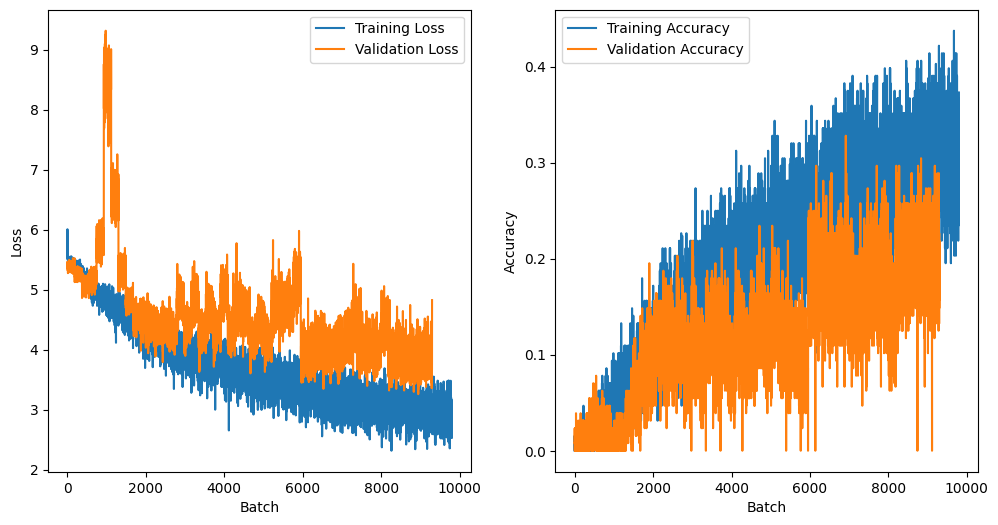

In [129]:
#plot losses and accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_per_batch_losses, label='Training Loss')
plt.plot(validation_per_batch_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training_per_batch_accuracies, label='Training Accuracy')
plt.plot(validation_per_batch_accuracies, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()